**Initial Data Processing**

Importing as an array file, and suppressing zeros from dataset

> Replace the '**FileName**' field for the filename to be analyzed;

> All the csv files must be in the same location as the python file.

In [1]:
import csv

FileName = 'CEM I.csv'
SupressZeros = True

# importing csv file as an array file
with open(FileName) as csv_file:
    csv_file = list(csv.reader(csv_file, delimiter=';'))

# with zero supressing
if SupressZeros:
    csv_zero_suppressed = csv_file
    for _index in range(len(csv_zero_suppressed) - 1, 0, -1):
        if csv_zero_suppressed[_index][1] == '0':
            del csv_zero_suppressed[_index]
    x_header = csv_zero_suppressed[0][0]
    x_axis = [float(_lines[0].replace(',','.')) for _lines in csv_zero_suppressed[1:]]
    y_header = csv_zero_suppressed[0][1]
    y_axis = [float(_lines[1].replace(',','.')) for _lines in csv_zero_suppressed[1:]]

# without zero suppressing
else:
    x_header = csv_file[0][0]
    x_axis = [float(_lines[0].replace(',','.')) for _lines in csv_file[1:]]
    y_header = csv_file[0][1]
    y_axis = [float(_lines[1].replace(',','.')) for _lines in csv_file[1:]]

**Smoothing the Data using ANN Regressor (MLP Regressor)**

Implementation using an Multilayer Perceptron Regressor

> For optimization you must change the **hidden_layer_sizes** and **max_iter** only. All the rest was tested to fit the best **R2 Score** and minimal **RMSE** for that kind of data;

> A strategy for decrease the signal noise is decrease the **hidden layer size** and the **max iter** params.

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#input definition
X, y = pd.DataFrame(x_axis), pd.DataFrame(y_axis)
X = X.values.reshape(-1,1)

# dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


# ANN definition
regressor = MLPRegressor(hidden_layer_sizes=(1000, 100),
                         activation='tanh',
                         solver='lbfgs',
                         max_iter=2000,
                         random_state=0,
                         tol=0.001)

# model fitting
regressor.fit(X_train, y_train)

# range prediction
y_predicted = regressor.predict(X)

**Initial Data Visualization**

Comparison between the original data and ANN Model Generated, using error metrics to evaluate the proposed model

> R2 score is a metric that evaluate the model performance. So that as our regression line moves towards perfection, R2 score move towards 1. And the model performance improves.

> The MAE measures the average magnitude of the errors in a set of forecasts, without considering their direction. It measures accuracy for continuous variables.

> The RMSE is a quadratic scoring rule which measures the average magnitude of the error. The equation for the RMSE is given in both of the references.

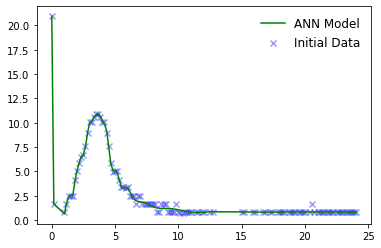

In [3]:
# Graph plotting
plt.scatter(x_axis, y_axis, marker='x', color='blue', alpha=0.4, label='Initial Data')
plt.plot(x_axis, y_predicted, color='green', label='ANN Model')
plt.legend(loc='upper right', frameon=False, fontsize=12)
plt.show()

**True vs Predicted**

For a good fit, the points should be close to the fitted line, with narrow confidence bands. Points on the left or right of the plot, furthest from the mean, have the most leverage and effectively try to pull the fitted line toward the point. Points t
hat are vertically distant from the line represent possible outliers. Both types of points can adversely affect the fit.

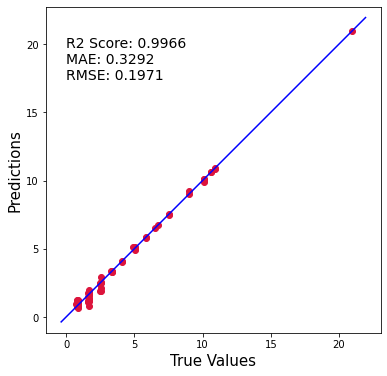

In [4]:
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# main plot definition
plt.figure(figsize=(6,6))
plt.scatter(y_axis, y_predicted, c='crimson')

# axis limits
p1 = max(max(y_predicted) + 1, max(y_axis) + 1)
p2 = min(min(y_predicted) - 1, min(y_axis) - 1)

plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')

# error metrics evaluation
_metric1 = 'R2 Score: {:.4f}'.format(float(r2_score(y_axis, y_predicted)))
_metric2 = 'MAE: {:.4f}'.format(sqrt(mean_absolute_error(y_axis, y_predicted)))
_metric3 = 'RMSE: {:.4f}\n'.format(sqrt(mean_squared_error(y_axis, y_predicted, squared=True)))

plt.text(0, 15, _metric1 + '\n' + _metric2 + '\n' +_metric3 + '\n', fontsize=14)
plt.show()

**Boxplot Distribution**

In descriptive statistics, a box plot or boxplot is used in explanatory data analysis. Box plots visually show the distribution of numerical data and skewness through displaying the data quartiles (or percentiles) and averages.

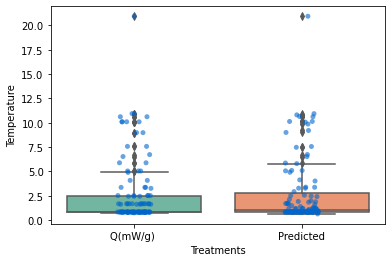

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data file
df = pd.DataFrame({y_header + ' ': y_axis, 'Predicted':y_predicted})

# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['index'])

# replace column names
df_melt.columns = ['index', 'Treatments', 'Temperature']

sns.set_palette('Set2')
sns.boxplot(x='Treatments', y='Temperature', data=df_melt)
sns.stripplot(x='Treatments', y='Temperature', data=df_melt, color='#0066cc', alpha=0.6)
plt.show()

**ANOVA Analysis (Variance Analysis)**

Analysis of variance, or ANOVA, is a statistical method that separates observed variance data into different components to use for additional tests.

In [6]:
try:
    import bioinfokit
except ModuleNotFoundError:
    !pip install bioinfokit
from bioinfokit.analys import stat

# model definition and summary
anova = stat()
anova.anova_stat(df=df_melt, res_var='Temperature', anova_model='Temperature ~ C(Treatments)')
anova.anova_summary

     |████████████████████████████████| 84 kB 2.2 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56750 sha256=06ff401c27fe832ee7199ca8e080ce077e203f8e49e2c7b870c1ef18115da45d
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=b7341823b2408e5a78682f72bea69f0db4b27e4797ea01a716505fbf040d502a
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,df,sum_sq,mean_sq,F,PR(>F)
C(Treatments),1.0,0.010260,0.010260,0.0009,0.976097
Residual,218.0,2485.845808,11.402962,NaN,NaN


**Quantiles, Standardized Residuals and Frequency Plots**

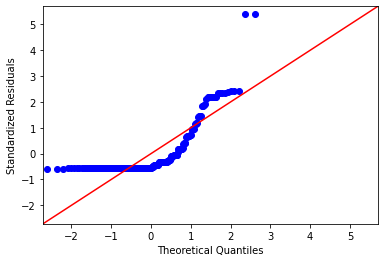

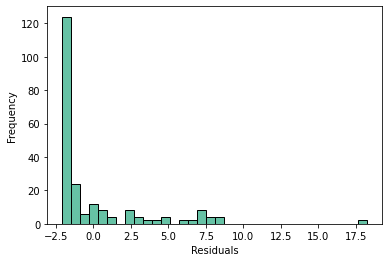

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(anova.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(anova.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

**TUKEY HSD Test**

Alternatively, Scheffe’s method is completely coherent with ANOVA and considered as more appropriate post hoc test for significant ANOVA for all unplanned comparisons. However, it is highly conservative than other post hoc tests.

In [8]:
import warnings
from bioinfokit.analys import stat

# warning suppressing
warnings.simplefilter(action='ignore', category=FutureWarning)

# model definition and summary
tukey = stat()
tukey.tukey_hsd(df=df_melt, res_var='Temperature', xfac_var='Treatments', anova_model='Temperature ~ C(Treatments)')
tukey.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Q(mW/g),Predicted,0.013658,-0.883757,0.911073,0.042421,0.9


**Shapiro-Wilk Test**

Can be used to check the normal distribution of residuals. Null hypothesis: data is drawn from normal distribution

In [9]:
from bioinfokit.analys import stat

# model definition and summary
shapiro = stat()
shapiro.bartlett(df=df_melt, res_var='Temperature', xfac_var='Treatments')
shapiro.bartlett_summary

,Parameter,Value
0,Test statistics (T),0.0001
1,Degrees of freedom (Df),1.0000
2,p value,0.9922


**Levene's Test**

Can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [10]:
from bioinfokit.analys import stat 

# model definition and summary
levene = stat()
levene.levene(df=df_melt, res_var='Temperature', xfac_var='Treatments')
levene.levene_summary

,Parameter,Value
0,Test statistics (W),0.0032
1,Degrees of freedom (Df),1.0000
2,p value,0.9546


**Numerical Derivation Process**


Return the gradient of an N-dimensional array.

> The gradient is computed using second order accurate central differences in the interior points and either first or second order accurate one-sides (forward or backwards) differences at the boundaries. The returned gradient hence has the same shape as the input array.

Docs: https://numpy.org/doc/stable/reference/generated/numpy.gradient.html

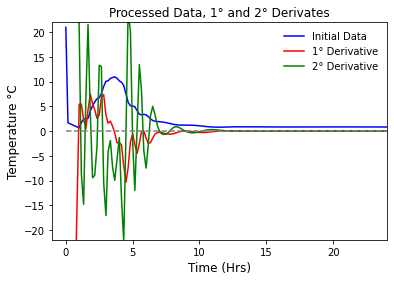

In [11]:
import numpy as np

x_initial = np.array(x_axis)
y_initial = np.array(y_predicted)

# derivation process
der1 = np.gradient(y_initial,x_initial)
der2 = np.gradient(der1,x_initial)

# graph labels
plt.title("Processed Data, 1° and 2° Derivates", fontsize=12)
plt.ylabel("Temperature °C", fontsize=12)
plt.xlabel("Time (Hrs)", fontsize=12)

# data series
plt.plot(x_initial, y_initial, color='blue', label='Initial Data')
plt.plot(x_initial, der1, color='red', label='1° Derivative')
plt.plot(x_initial, der2, color='green', label='2° Derivative')
plt.plot(np.zeros_like(x_initial), "--", color="gray")
plt.legend(loc='upper right', frameon=False)

# graph limits
plt.xlim(-1, max(x_axis))
plt.ylim(-max(y_axis) - 1, max(y_axis) + 1)
plt.show()

**Signal Finds Peaks and Valleys**

Find peaks inside a signal based on peak properties.

> This function takes a 1-D array and finds all local maxima by simple comparison of neighboring values. Optionally, a subset of these peaks can be selected by specifying conditions for a peak’s properties.

Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [12]:
import numpy as np
from scipy.signal import find_peaks

# peaks and valleys identification
tops, _ = find_peaks(y_predicted, distance=30)
valleys, _ = find_peaks(-y_predicted, distance=30)
peaks = np.concatenate((tops, valleys), axis = 0)
peaks.sort(axis=0)

<Figure size 1152x576 with 0 Axes>

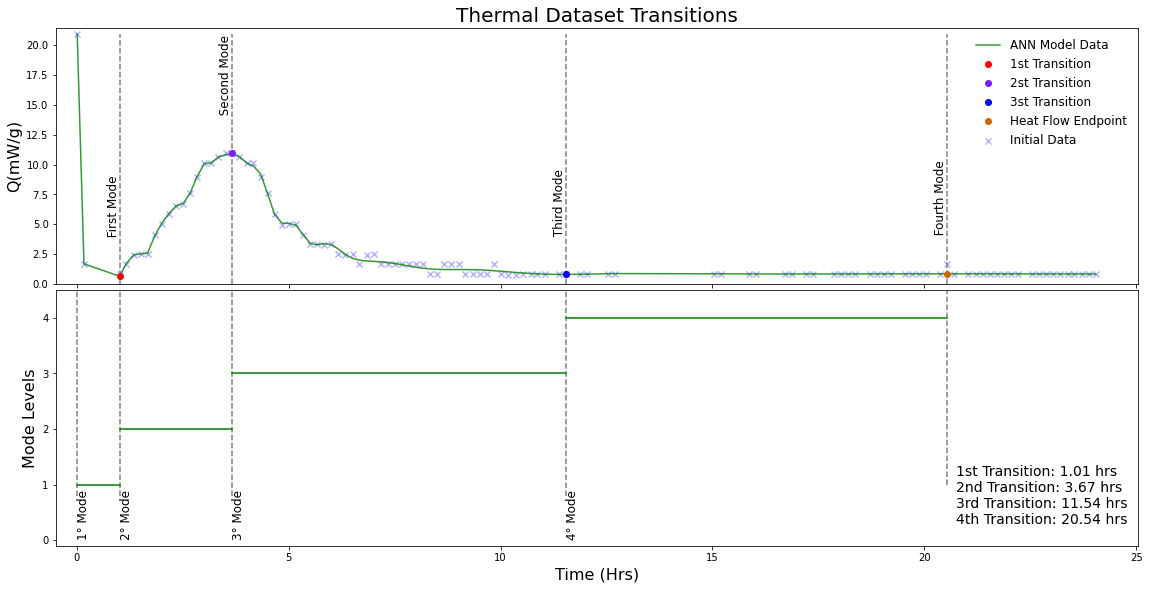

In [13]:
import matplotlib.pyplot as plt

# graph size and main definitions
plt.rcParams["figure.figsize"] = (16,8)
plt.subplots_adjust(hspace = .001)
fig, ax = plt.subplots(2, 1, sharex='col', sharey='row')

# initial graph
ax[0].scatter(x_axis, y_axis, marker='x', color='blue', alpha=0.3, label='Initial Data')
ax[0].plot(x_axis, y_predicted, color="green", alpha=0.8, label='ANN Model Data')

# zones transition identification
_prompt1 = '1st Transition: {:.2f} hrs'.format(x_axis[peaks[0]])
ax[0].plot(x_axis[peaks[0]], y_predicted[peaks[0]], "o", color="red", label='1st Transition')
ax[0].vlines(x_axis[peaks[0]], 0, max(y_predicted), color="gray", linestyles='dashed')  # vertical zones
ax[0].text(x_axis[peaks[0]], y_predicted[peaks[0]], '          First Mode',
         rotation='vertical', fontsize=12, ha='right', va='bottom')  # data labels

_prompt2 = '2nd Transition: {:.2f} hrs'.format(x_axis[peaks[1]])
ax[0].plot(x_axis[peaks[1]], y_predicted[peaks[1]], "o", color=(0.5, 0.1, 1), label='2st Transition')
ax[0].vlines(x_axis[peaks[1]], 0, max(y_predicted), color="gray", linestyles='dashed')  # vertical zones
ax[0].text(x_axis[peaks[1]], y_predicted[peaks[1]], '          Second Mode',
         rotation='vertical', fontsize=12, ha='right', va='bottom')  # data labels

_prompt3 = '3rd Transition: {:.2f} hrs'.format(x_axis[peaks[-2]])
ax[0].plot(x_axis[peaks[-2]], y_predicted[peaks[-2]], "o", color=(0, 0, 1), label='3st Transition')
ax[0].vlines(x_axis[peaks[-2]], 0, max(y_predicted), color="gray", linestyles='dashed')  # vertical zones
ax[0].text(x_axis[peaks[-2]], y_predicted[peaks[-2]], '          Third Mode',
         rotation='vertical', fontsize=12, ha='right', va='bottom')  # data labels

_prompt4 = '4th Transition: {:.2f} hrs\n'.format(x_axis[peaks[-1]])
ax[0].plot(x_axis[peaks[-1]], y_predicted[peaks[-1]], "o", color=(0.8, 0.4, 0), label='Heat Flow Endpoint')
ax[0].vlines(x_axis[peaks[-1]], 0, max(y_predicted), color="gray", linestyles='dashed')  # vertical zones
ax[0].text(x_axis[peaks[-1]], y_predicted[peaks[-1]], '          Fourth Mode',
         rotation='vertical', fontsize=12, ha='right', va='bottom')  # data labels

ax[0].legend(loc='upper right', frameon=False, fontsize=12)


# staircase graph
_mod_steps = [0, x_axis[peaks[0]], 
              x_axis[peaks[1]],
              x_axis[peaks[-2]],
              x_axis[peaks[-1]]]
_levels = [1,2,3,4,4]

for _index in range(0, len(_mod_steps) - 1):
    _x_start = _mod_steps[_index]
    _x_end = _mod_steps[_index + 1]
    _level = _levels[_index]
    
    ax[1].plot([_x_start, _x_end], [_level, _level], color='green', alpha=1)  # step line
    ax[1].vlines(_x_start, 0.8, max(_levels) + 1, color="gray", linestyles='dashed')  # vertical zones
    ax[1].text(_x_start, 0, f'{_index + 1}° Mode', rotation='vertical',
               fontsize=12, ha='left', va='bottom')  # data labels

# last vertical zone
ax[1].vlines(_mod_steps[-1], 1, max(_levels) + 1, color="gray", linestyles='dashed')

# graph limits
ax[0].set_xlim([-0.5, max(x_axis) + 1])
ax[0].set_ylim([0, max(y_predicted) + 0.5])
ax[1].set_ylim([-0.1, 4.5])

# graph labels
ax[0].set_title('Thermal Dataset Transitions', fontsize=20)
ax[0].set_ylabel(y_header, fontsize=16)
ax[1].set_ylabel('Mode Levels', fontsize=16)
ax[1].set_xlabel('Time (Hrs)', fontsize=16)

ax[1].text(_mod_steps[-1] + 0.2, 0, _prompt1 + '\n' + _prompt2 + '\n' +_prompt3 + '\n' +_prompt4, fontsize=14)

plt.tight_layout(pad=0, h_pad=None, w_pad=None, rect=None)
plt.show()